In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import copy
import math
import numpy as np
import glob
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass

In [2]:
from umap import UMAP
import hdbscan
import datamapplot

In [3]:
torch.manual_seed(1337)
random.seed(1337)

def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    # elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    #     device = 'mps'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cpu


In [4]:
data_dir = Path('/Users/djemec/data/jepa/v0_2')
mask_path = data_dir / 'binary_pathway_mask.npy'
pert_dir = data_dir / 'pert_embd'
metadata_path = pert_dir / 'pert_to_id.json'
checkpoint_dir = data_dir / 'checkpoint'
gene_names_path = data_dir / 'gene_names.json'

## Load Model Checkpoint

In [5]:
import biojepa_ac_model as model
BATCH_SIZE = 32
n_embd = 8
n_pathways = 1024
PT_EPOCHS = 10
training_file_chunk = 25000
pretraining_file_chunk = 50000
n_heads = 2
n_layers = 2

In [6]:
print('Loading Pathway Mask...')
binary_mask = np.load(mask_path)
n_genes, n_pathways = binary_mask.shape
print(f'Mask Loaded: {n_genes} Genes -> {n_pathways} Pathways')

with open(metadata_path, 'r') as f:
    pert_to_id = json.load(f)
id_to_pert = {v: k for k, v in pert_to_id.items()}
print(f'Loaded {len(id_to_pert.keys())} perturbations')

with open(gene_names_path, 'r') as f:
    gene_names = json.load(f)
print(f'Loaded {len(gene_names)} genes')

Loading Pathway Mask...
Mask Loaded: 5000 Genes -> 1024 Pathways
Loaded 1088 perturbations
Loaded 5000 genes


In [7]:
pert_embd_path = pert_dir / 'action_embeddings_esm2.npy'
pert_embd = np.load(pert_embd_path)

In [8]:
config = model.BioJepaConfig(
    mask_matrix=binary_mask, 
    num_genes=n_genes,
    num_pathways=n_pathways,
    embed_dim=n_embd,
    n_layer=n_layers,
    heads=n_heads,
    n_pre_layer = n_layers
)
model = model.BioJepa(config, pert_embd=pert_embd).to(DEVICE)

In [9]:
#checkpoint_path = checkpoint_dir / 'bio_jepa_ckpt_6353_final.pt'
checkpoint_path = checkpoint_dir / 'bio_jepa_ckpt_31769_final.pt'
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

keys = model.load_state_dict(checkpoint['model'])
keys

<All keys matched successfully>

In [10]:
gene_embd = model.student.gene_embeddings.detach().cpu().float().numpy()
embd = gene_embd
gene_embd.shape

(5000, 8)

In [11]:
n = gene_embd.shape[0]
n

5000

In [12]:
labels = np.asarray(gene_names) 

## Load Perturbation Embeddings

In [8]:
pert_dir = data_dir / 'pert_embd'
pert_id_file = pert_dir / 'pert_to_id.json'
pert_embd_file = pert_dir / 'action_embeddings_esm2.npy'

In [11]:
pert_embd = np.load(pert_embd_file)
pert_embd.shape

(1087, 320)

In [18]:
with open(pert_id_file, 'r') as f:
    pert_to_id = json.load(f)
all_perts = [i for i in pert_to_id.keys() if i != 'control']
len(all_perts)

1087

In [19]:
n = pert_embd.shape[0]
n

1087

In [20]:
labels = np.asarray(all_perts) 

## Visualizations

In [13]:
coords = UMAP(
    n_components=2, 
    n_neighbors=30, 
    min_dist=0.5, 
    spread=2.0, 
    metric="cosine", 
    random_state=0).fit_transform(embd)

/opt/miniconda3/envs/general/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<InteractiveFigure width=100% height=800>
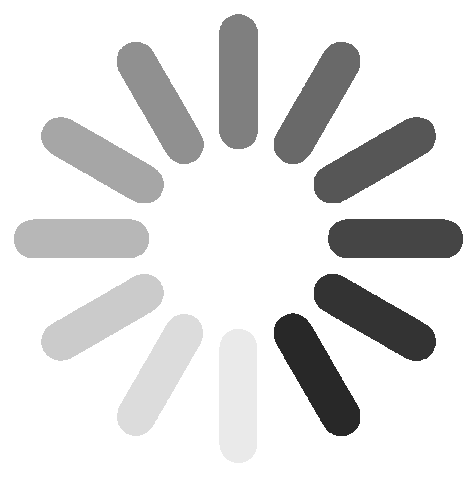

In [14]:
datamapplot.create_interactive_plot(coords, labels)

In [15]:
from sklearn.manifold import TSNE

In [16]:
coords = TSNE(
    n_components=2,
    perplexity=30,      
    learning_rate='auto',
    init='random',
    random_state=12
).fit_transform(embd)

<InteractiveFigure width=100% height=800>
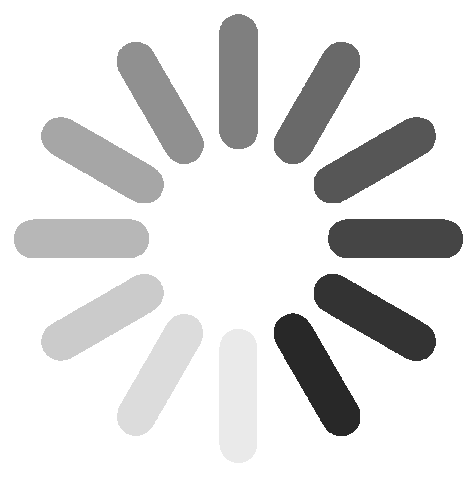

In [18]:
datamapplot.create_interactive_plot(coords, labels)